In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
train = pd.read_csv("twitter_training.csv")
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [3]:
valid = pd.read_csv("twitter_validation.csv")
valid.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [4]:
train.columns=['id','information','type','text']
train.head()

,id,information,type,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
valid.columns=['id','information','type','text']
valid.head()

,id,information,type,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74681 non-null  int64 
 1   information  74681 non-null  object
 2   type         74681 non-null  object
 3   text         73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           999 non-null    int64 
 1   information  999 non-null    object
 2   type         999 non-null    object
 3   text         999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [8]:
train.shape

(74681, 4)

In [9]:
valid.shape

(999, 4)

In [10]:
train.isnull().sum()

id               0
information      0
type             0
text           686
dtype: int64

In [11]:
valid.isnull().sum()

id             0
information    0
type           0
text           0
dtype: int64

In [12]:
train = train.dropna(subset=['text'])

In [13]:
train.isnull().sum()

id             0
information    0
type           0
text           0
dtype: int64

In [14]:
train['type'].value_counts()

Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: type, dtype: int64

In [15]:
valid['type'].value_counts()

Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: type, dtype: int64

### Visualize Data

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

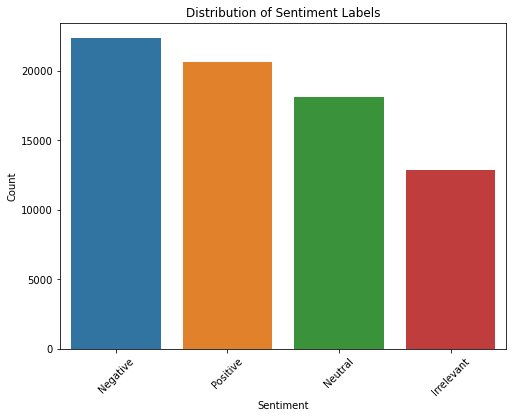

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='type', order=train['type'].value_counts().index)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

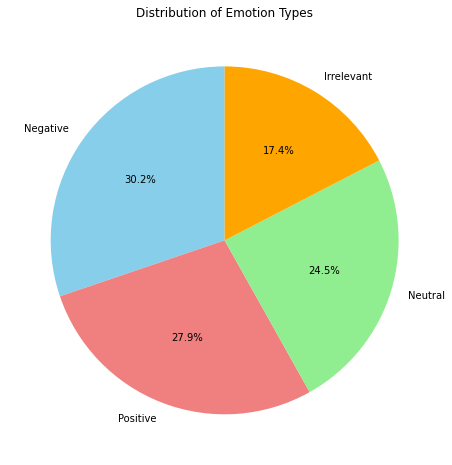

In [19]:
type_counts = train['type'].value_counts()

# Define colors for each emotion type
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Emotion Types')
plt.show()

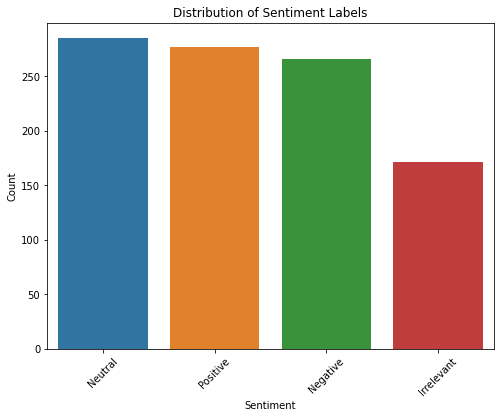

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=valid, x='type', order=valid['type'].value_counts().index)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

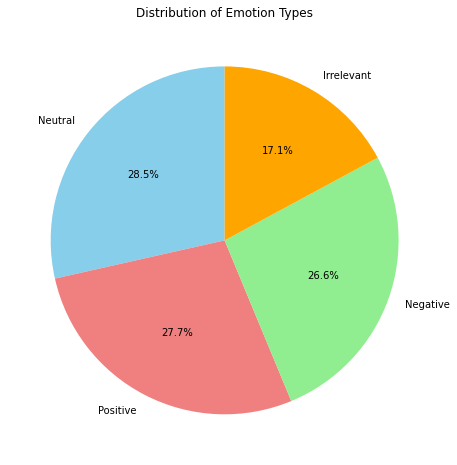

In [21]:
type_counts = valid['type'].value_counts()

# Define colors for each emotion type
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Emotion Types')
plt.show()

### Preprocessing data

In [22]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download NLTK resources if not already downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization and removing stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to C:\Users\D E L
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\D E L
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
# Apply the preprocess_text function to the 'text' column
train['preprocessed_text'] = train['text'].apply(preprocess_text)
train

,id,information,type,text,preprocessed_text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder
...,...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realized windows partition mac like years behi...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realized mac window partition years behind nvi...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realized windows partition mac years behind nv...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...,realized windows partition mac like years behi...


In [24]:
# Apply the preprocess_text function to the 'text' column
valid['preprocessed_text'] = valid['text'].apply(preprocess_text)
valid

,id,information,type,text,preprocessed_text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects claims...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word functions poorly samsungus ...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
3,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping americans face really commi...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi eahelp ive madeleine mccann cellar past yea...
...,...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,toronto arts culture capital canada wonder wan...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,actually good move tot bring viewers one peopl...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,today sucked time drink wine n play borderland...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,bought fraction microsoft today small wins


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the 'max_features' parameter based on your dataset

# Fit and transform the training data
tfidf_train_features = tfidf_vectorizer.fit_transform(train['preprocessed_text'])

# Transform the validation data using the same vectorizer
tfidf_validation_features = tfidf_vectorizer.transform(valid['preprocessed_text'])

# Display the shape of the TF-IDF features
print(f"TF-IDF Training Features Shape: {tfidf_train_features.shape}")
print(f"TF-IDF Validation Features Shape: {tfidf_validation_features.shape}")

TF-IDF Training Features Shape: (73995, 5000)
TF-IDF Validation Features Shape: (999, 5000)


In [35]:
!pip install xgboost

In [26]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the class labels in both training and validation datasets
train_labels_encoded = label_encoder.fit_transform(train['type'])
validation_labels_encoded = label_encoder.transform(valid['type'])

In [40]:
!pip install xgboost

In [42]:
conda install -c conda-forge xgboost


Note: you may need to restart the kernel to use updated packages.


In [27]:
!pip list  # or !conda list for Anaconda environments

Package                       Version
----------------------------- --------------------
absl-py                       0.15.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-client               1.9.0
anaconda-navigator            2.4.3
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
back

In [31]:
import sys
sys.executable

'C:\\ProgramData\\anaconda4\\python.exe'

In [32]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [33]:
!pip install xgboost

In [27]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the classifier on the TF-IDF training features and encoded labels
xgb_classifier.fit(tfidf_train_features, train_labels_encoded)

# Predict the encoded labels for the TF-IDF validation features
validation_predictions_xgb_encoded = xgb_classifier.predict(tfidf_validation_features)

# Decode the predicted labels back to the original class labels
validation_predictions_xgb = label_encoder.inverse_transform(validation_predictions_xgb_encoded)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Evaluate the performance of the XGBoost classifier
accuracy_xgb = accuracy_score(validation_df['type'], validation_predictions_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")

In [ ]:
# Display additional classification metrics for XGBoost
print("XGBoost Classification Report:")
print(classification_report(validation_df['type'], validation_predictions_xgb))

In [ ]:
# Display the confusion matrix for XGBoost
print("XGBoost Confusion Matrix:")
print(confusion_matrix(validation_df['type'], validation_predictions_xgb))

In [ ]:
# Assuming you have defined the preprocess_text function

# Example user input
user_input = "Platinum is the best loot @Borderlands"

# Preprocess the user input
user_input_processed = preprocess_text(user_input)

# Vectorize the user input using TF-IDF
user_input_tfidf = tfidf_vectorizer.transform([user_input_processed])

# Predict the sentiment type using the trained XGBoost model
prediction_encoded = xgb_classifier.predict(user_input_tfidf)[0]

# Decode the predicted label back to the original class label
predicted_type = label_encoder.inverse_transform([prediction_encoded])[0]

print(f"The predicted type for the input text is: {predicted_type}")

In [ ]:
# Assuming you have defined the preprocess_text function

# Example user input
user_input = "Platinum is the best loot @Borderlands"

# Preprocess the user input
user_input_processed = preprocess_text(user_input)

# Vectorize the user input using TF-IDF
user_input_tfidf = tfidf_vectorizer.transform([user_input_processed])

# Predict the sentiment type using the trained XGBoost model
prediction_encoded = xgb_classifier.predict(user_input_tfidf)[0]

# Decode the predicted label back to the original class label
predicted_type = label_encoder.inverse_transform([prediction_encoded])[0]

print(f"The predicted type for the input text is: {predicted_type}")